<a href="https://colab.research.google.com/github/BogdanDavidRomanovich/labs/blob/master/%D0%9C%D0%A1%D0%A13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
from itertools import permutations
from sklearn import datasets

In [ ]:
def corel(X, Y):
    var = 0
    m1 = X.mean()
    m2 = Y.mean()
    d1 = 0
    d2 = 0
    for x, y in zip(X, Y):
        var += (x - m1)*(y - m2)
        d1 += (x - m1)*(x - m1)
        d2 += (y - m2)*(y - m2)
    return var / ((d1 ** 0.5) * (d2 ** 0.5))

In [ ]:
def create_df(RSS_next,numOfColX,yShape):
    df = pd.DataFrame(columns=['s',  'Cp','RSS', 'FPE'])
    Cp = RSS_next + 2 * numOfColX
    numOfRowY = yShape
    FPE = (numOfRowY + numOfColX) / (numOfRowY - numOfColX) * RSS_next
    df = df.append({'s': numOfColX,  'Cp': Cp, 'RSS': RSS_next, 'FPE': FPE},  ignore_index=True)
    return df
def RMNK(X, y,W=None, s=None, printt=False, cr_df=False):
    numOfColX = X.shape[1]
    W = np.hstack((X.T @ X, (X.T @ y).reshape(-1, 1)))
    if numOfColX > 1:
        if cr_df:
            w, H_inv, RSS, df = RMNK(X[:,:-1], y, W[:-1,:],s, printt, cr_df)
            if s is not None and numOfColX > s:
                return w, H_inv, RSS, df
        else:
            w, H_inv, RSS = RMNK(X[:,:-1], y,W[:-1,:], s, printt, cr_df)
            if s is not None and numOfColX > s:
                return w, H_inv, RSS
        
        h = W[:numOfColX-1,numOfColX-1].reshape(-1,1)
        η  = W[numOfColX-1,numOfColX-1] 
        α = H_inv @ h 
        β  = η  - h.T @ α 
        β_inv = 1 /β  
        γ = W[numOfColX-1,-1]
        ν =β_inv * (γ - h.T @ w) 
        w = np.vstack((w - ν * α, ν))  
        H_next_inv = np.vstack((np.hstack((H_inv + β_inv * α @ α.T, (- β_inv * α).reshape(-1, 1))),
                               np.hstack((-β_inv * α.T, β_inv))))
        RSS_next = (RSS - ν.flatten() ** 2 * β.flatten())[0]

    else: 
        H_inv = np.array([[0]])
        η  = β =  W[0,0] 
        β_inv = 1 / β
        α = h = np.array([0])
        γ = W[0, -1] 
        ν = np.array([β_inv * γ])
        w = np.array([ν])
        H_next_inv = np.array(β_inv).reshape(1, 1)
        RSS_next = (y.T @ y -  W[0, -1:] @ w)[0]
        if cr_df:
            df = pd.DataFrame(columns=['s',  'Cp','RSS', 'FPE', 'theta'])
        
    if printt:
        print('Step №{}'.format(numOfColX))
        '''print('h_{}:{}'.format(numOfColX, h.reshape(-1,1)[:,0]))
            print('η _{}:{}'.format(numOfColX, η ))
            print('α_{}:{}'.format(numOfColX, α.reshape(-1,1)[:,0]))
            print('β_{}:{}'.format(numOfColX, β))
            print('γ_{}:{}'.format(numOfColX, γ))
            print('ν_{}:{}'.format(numOfColX, ν))'''
        print('---θ{}: {}'.format(numOfColX, w[:, 0]))
        print('---H{}_inv:\n{}'.format(numOfColX, H_next_inv))
        print('---RSS{}: {}'.format(numOfColX, RSS_next))
    
    if cr_df:
        Cp = RSS_next + 2 * numOfColX
        numOfRowY = y.shape[0]
        FPE = (numOfRowY + numOfColX) / (numOfRowY - numOfColX) * RSS_next
        df = df.append({'s': numOfColX, 'Cp': Cp, 'RSS': RSS_next, 'FPE': FPE,'theta': w[:, 0]},ignore_index=True)
        return w, H_next_inv, RSS_next, df
    return w, H_next_inv, RSS_next
def A1(X,y,m,s,sequence=None, plot=False,crs=['Cp', 'FPE', 'RSS']):
    print('\n-----------------------A1------------------------------')
    if sequence == 'reverse':
        print('Reverse:')
        sequence = np.flip(np.arange(m), axis=0)
    elif sequence == 'correlation':
        print('Using correlations:')
        correlations = np.abs(np.cov(X.T, y.T)[-1,:-1])
        sequence = np.argsort(-correlations)
        corr = []
        i = 0
        for x in X.T:
            i += 1
            corr.append(corel(x, y))
        print(corr)

    else:
        print('Direct:')
        sequence = np.arange(m)
    print('Order of Regressors: {}'.format(sequence+1))
    theta_pred, _, _, df = RMNK(X[:,sequence], y, s=s,  cr_df=True)
    df['regressors'] = [str(sorted(sequence[:int(s)]+1)) for s in df.s]
    for crit in crs:
        df[crit] = np.round(df[crit], 6)
    if plot:
        for crit in crs:
            plt.plot(df['s'], df[crit], label=crit)
        plt.legend()
        plt.show()
    df = df.sort_values(by=crs).reset_index()[['s', 'regressors', 'theta'] + crs]
    s_opt, regr_opt,theta_opt = df.loc[0, ['s', 'regressors', 'theta']]
    theta_opt = np.hstack((theta_opt,np.zeros(m - len(theta_opt))))[np.argsort(sequence)]
    df = df.drop(['theta'], axis = 1)
    print('Optimal:')
    print('s* = {}'.format(s_opt))
    print('regressors = {}'.format(regr_opt))
    print('theta* = {}'.format(theta_opt))
    print("results:\n")
    print(df)

def A2(X,y,m,s, K=20,crs=['Cp', 'FPE', 'RSS'],min_crit='Cp'):
    print('\n-----------------------A2------------------------------')
    print('K = {}'.format(K))
    permuts = [np.random.permutation(m) for i in range(K)]
    all_df = pd.DataFrame()
    opt_df = pd.DataFrame()
    min_cr = np.Inf
    for sequence in permuts:
        sequence = np.array(sequence)
        stheta_pred, _, _, df = RMNK(X[:,sequence], y, s=s,cr_df=True)
        df = df.drop(['theta'], axis = 1)
        df['regressors'] = [str(sorted(sequence[:int(s)]+1)) for s in df.s]
        df = df.sort_values(by=crs).reset_index()
        smin_cr = df.loc[0, min_crit]
        if smin_cr < min_cr:
            min_cr = smin_cr
            theta_pred = stheta_pred
            s_opt, regr_opt = df.loc[0,['s', 'regressors']]
        all_df = pd.concat([all_df, df], axis=0)
        opt_df = pd.concat([opt_df, df.loc[0:0]], axis=0)
    for crit in crs:
        all_df[crit] = np.round(all_df[crit], 6)
        opt_df[crit] = np.round(opt_df[crit], 6)
    all_df = all_df.drop_duplicates()
    all_df = all_df.sort_values(by=crs).reset_index()[['s', 'regressors'] + crs]
    opt_df = opt_df.rename(columns={'s': 's*','regressors': 'regressors*'}).reset_index()[['s*', 'regressors*'] + crs]
    print(opt_df)
    print('Optimal:')
    print('s* = {}'.format(s_opt))
    print('regressors = {}'.format(regr_opt))
    return opt_df

def A3(X,y,m,s,crs=['Cp', 'FPE', 'RSS'], min_crit='Cp'):
    print('\n-----------------------A3------------------------------')
    all_df = pd.DataFrame()
    opt_df = pd.DataFrame()
    smin_cr = np.Inf
    indexes = list(range(m))
    complexity_cycle = []
    while len(indexes) > 0:
        min_cr2 = np.Inf
        for i in indexes:
            p = np.array(complexity_cycle + [i])
            theta_pred, _, _, df = RMNK(X[:,p], y, s=len(p),cr_df=True)
            df = df.drop(['theta'], axis = 1)
            df['regressors'] = [str(sorted(p[:int(s)]+1)) for s in df.s]
            df = df.sort_values(by=crs).reset_index()
            min_cr = df.loc[0, min_crit]
            if min_cr < min_cr2:
                min_cr2 = min_cr
                df2 = df[:1]
                i2 = i
            if min_cr < smin_cr:
                smin_cr = min_cr
                stheta_pred = theta_pred
                s_opt, regr_opt = df.loc[0, ['s', 'regressors']]
            all_df = pd.concat([all_df, df], axis=0)
        complexity_cycle += [i2]
        indexes.remove(i2)
        opt_df = pd.concat([opt_df, df2], axis=0)
    for crit in crs:
        all_df[crit] = np.round(all_df[crit], 6)
        opt_df[crit] = np.round(opt_df[crit], 6)
    all_df = all_df.drop_duplicates().reset_index()[['s', 'regressors'] + crs]
    opt_df = opt_df.rename(columns={'s': 's*','regressors': 'regressors*'}).reset_index()[['s*', 'regressors*'] + crs]
    opt_df = opt_df.drop_duplicates().reset_index()[['s*', 'regressors*'] + crs]
    print('Optimal:')
    print('s* = {}'.format(s_opt))
    print('regressors = {}'.format(regr_opt))
    return all_df, opt_df
m=15
n = 500
s = 10
theta = np.array([1, 9, -8, 7, -6, 5,-4, 3, -2, -10, 0, 0, 0, 0, 0])
sigma = 0.3
X = np.random.uniform(0, 2, size=(n, m))
ksi = np.random.normal(0, sigma, size=n)
y = X @ theta + ksi
W = X.T@X
W0 = X.T@y
W0=W0[:, np.newaxis]
Wnew = np.hstack((W,W0))        
print('m = {}'.format(m))
print('σ = {}'.format(sigma))
print('n = {}'.format(n))
print('X[:20]:{}'.format(X[:20]))
print('y[:20]:{}'.format(y[:20]))


m = 15
σ = 0.3
n = 500
X[:20]:[[0.24641419 0.01107891 1.10703859 0.87711477 0.03613715 1.23934111
  1.54810009 0.18010467 1.89076769 1.33170861 0.04640208 0.53945992
  1.63968957 0.26357771 1.74388422]
 [1.62631909 0.26722726 1.05983016 1.19979431 0.38682975 1.03046532
  1.20731372 1.40872205 0.75221644 0.38291608 0.51958271 1.45714504
  1.76418383 0.56097645 1.63221812]
 [1.43178985 0.62959233 1.13515178 0.27451312 0.45173302 1.64557041
  1.61147136 1.18359553 1.63195131 0.34285885 1.72619059 1.78097922
  1.09075472 0.87891405 1.43124071]
 [0.52890455 0.78425281 0.1614138  0.59626662 0.94435196 1.50449061
  0.44833632 0.5435922  0.41264769 1.38149353 1.12488334 1.25979623
  0.76421251 0.44546082 0.02888397]
 [0.6798411  1.46617477 1.36446953 0.46683076 0.56284311 1.39021811
  0.9547526  0.99325068 1.93980625 1.98905046 0.28483484 1.52104726
  0.03155716 1.33622494 1.04422212]
 [0.31114331 1.70024564 1.61294557 1.27737266 0.25031913 1.99949146
  1.43058377 1.13124833 0.66640744 1.36884


# Метод кореляційного включення

True theta: [  1   9  -8   7  -6   5  -4   3  -2 -10   0   0   0   0   0]

-----------------------A1------------------------------
Using correlations:
[0.052773140389576874, 0.4882375156987131, -0.38720993096436696, 0.3887842496757481, -0.31949068436104, 0.23697821684897896, -0.20868532929750552, 0.19518019120131724, -0.1776708953728399, -0.5031095032319033, 0.05875299406876916, 0.03895657348977672, -0.014601744459434981, -0.028865390703625787, 0.011266059652126015]
Order of Regressors: [10  2  3  4  5  6  7  8  9 11  1 12 14 13 15]


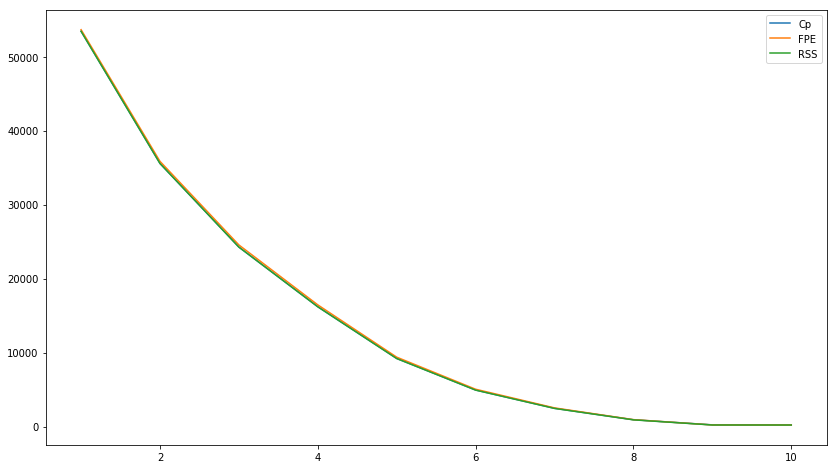

Optimal:
s* = 10
regressors = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
theta* = [ 0.          9.0345249  -7.85374863  7.15182853 -5.92477291  5.11141038
 -3.88183182  3.05317638 -1.93515953 -9.95549034  0.18045278  0.
  0.          0.          0.        ]
results:

    s                        regressors  ...           FPE           RSS
0  10  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  ...    208.221895    200.056331
1   9      [2, 3, 4, 5, 6, 7, 8, 9, 10]  ...    213.066986    205.532201
2   8         [2, 3, 4, 5, 6, 7, 8, 10]  ...    929.017492    899.757099
3   7            [2, 3, 4, 5, 6, 7, 10]  ...   2516.733579   2447.237978
4   6               [2, 3, 4, 5, 6, 10]  ...   5041.070394   4921.519317
5   5                  [2, 3, 4, 5, 10]  ...   9377.130620   9191.444865
6   4                     [2, 3, 4, 10]  ...  16447.725296  16186.650291
7   3                        [2, 3, 10]  ...  24550.964321  24258.109875
8   2                           [2, 10]  ...  35855.797320  35570.093756
9   1       

In [ ]:
print('True theta: {}'.format(theta))
A1(X,y,m,s,sequence='correlation',crs=['Cp', 'FPE', 'RSS'],plot=True)

# Метод випадкового включення

In [ ]:
Ks = [20, 30, 50]
for K in Ks:
    A2(X,y,m,s,K=K, crs=['Cp', 'FPE', 'RSS'],min_crit='Cp')



-----------------------A2------------------------------
K = 20
    s*                          regressors*  ...           FPE           RSS
0   10  [1, 3, 5, 6, 8, 10, 11, 12, 14, 15]  ...  28438.335194  27323.106363
1   10  [2, 3, 4, 5, 9, 10, 11, 12, 14, 15]  ...   8988.694336   8636.196519
2   10  [2, 4, 6, 7, 8, 10, 11, 12, 13, 15]  ...  22098.827791  21232.207094
3   10  [1, 2, 3, 5, 7, 10, 11, 13, 14, 15]  ...  17017.901147  16350.532474
4   10   [1, 3, 5, 6, 7, 9, 10, 12, 14, 15]  ...  31188.349225  29965.276707
5   10   [1, 2, 4, 5, 6, 8, 10, 11, 14, 15]  ...  18478.998886  17754.332263
6   10    [1, 3, 4, 5, 7, 8, 9, 10, 11, 12]  ...  21049.767924  20224.286829
7   10  [2, 4, 6, 8, 9, 11, 12, 13, 14, 15]  ...  48508.880391  46606.571356
8   10   [2, 5, 6, 7, 8, 9, 10, 11, 13, 14]  ...  19527.447455  18761.665202
9   10  [1, 6, 7, 8, 9, 10, 11, 12, 14, 15]  ...  39335.744956  37793.166722
10  10    [1, 2, 3, 4, 5, 7, 8, 10, 12, 13]  ...   4941.237017   4747.463016
11  10    [1

# Метод перебірного включення

In [ ]:
all_df, opt_df = A3(X,y,m,s,crs=['Cp', 'FPE', 'RSS'],min_crit='Cp')
print("All iterations:")
print(all_df)
print("Best iterations:")
print(opt_df)



-----------------------A3------------------------------
Optimal:
s* = 10
regressors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
All iterations:
      s  ...           RSS
0     1  ...  71076.818686
1     1  ...  77835.763372
2     1  ...  57483.130506
3     1  ...  76411.691659
4     1  ...  60191.507209
5     1  ...  74424.488942
6     1  ...  63874.646540
7     1  ...  73971.659237
8     1  ...  64905.501468
9     1  ...  53448.122890
10    1  ...  71033.263062
11    1  ...  70524.699908
12    1  ...  69232.445931
13    1  ...  69186.993624
14    1  ...  69929.781849
15    2  ...  51181.642500
16    2  ...  35570.093756
17    2  ...  51712.387032
18    2  ...  41071.193417
19    2  ...  52882.529492
20    2  ...  45656.658483
21    2  ...  53434.921644
22    2  ...  46986.976590
23    2  ...  53343.188278
24    2  ...  50703.916122
25    2  ...  51028.547394
26    2  ...  52028.001732
27    2  ...  52493.546666
28    2  ...  51715.650790
29    3  ...  35523.866118
..   ..  ...           ...
9

# зворотні параметри РМНКО

n = 200
σ = 0.3
X:[[8.23371076 8.40629957 4.39430369 ... 5.22290601 7.43378591 3.73308916]
 [5.82167612 4.95247924 5.7700189  ... 3.32872872 9.52261064 4.86744384]
 [9.38255747 0.62805364 9.927607   ... 5.29433332 3.52824329 6.77503485]
 ...
 [2.74884239 7.76233855 6.47841047 ... 0.07551071 5.81413931 5.35176773]
 [9.11093377 0.02859419 3.78102976 ... 3.64182906 1.61657983 1.92626145]
 [5.70411811 1.28988862 5.72694791 ... 6.31617226 2.0532988  3.11155179]]
y:[613.56675989 563.25181256 620.93108233 625.84646649 549.87179452
 702.56887278 447.69757345 462.21736193 433.168823   559.43481396
 379.7061569  501.61770611 373.7428148  542.0315252  482.72085212
 535.45913925 506.89465001 488.71598924 381.12158776 548.71644271
 485.2865398  479.1415166  489.33180606 304.72068654 519.36396784
 637.62797053 511.96416436 592.74913844 395.21545704 462.22608208
 374.91959804 394.67684553 562.76333881 550.34031407 442.9386272
 395.02567683 613.9190189  565.96763518 432.01860799 502.5823369
 546.20584

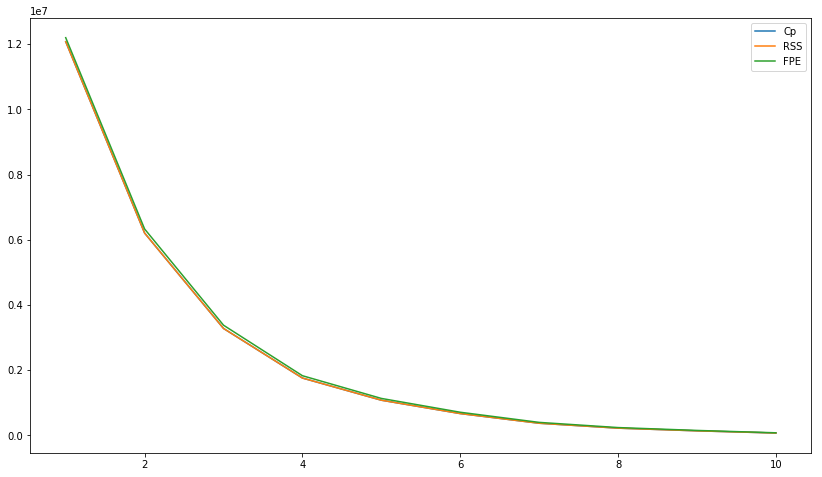

    s            Cp           RSS           FPE
9  10  6.873098e+04  6.871098e+04  7.594371e+04
8   9  1.358364e+05  1.358184e+05  1.486181e+05
7   8  2.182751e+05  2.182591e+05  2.364474e+05
6   7  3.688461e+05  3.688321e+05  3.955868e+05
5   6  6.652099e+05  6.651979e+05  7.063442e+05
4   5  1.075608e+06  1.075598e+06  1.130757e+06
3   4  1.755554e+06  1.755546e+06  1.827201e+06
2   3  3.277033e+06  3.277027e+06  3.376835e+06
1   2  6.203490e+06  6.203486e+06  6.328809e+06
0   1  1.207710e+07  1.207710e+07  1.219848e+07


-----------------------A1------------------------------
Reverse:
Order of Regressors: [15 14 13 12 11 10  9  8  7  6  5  4  3  2  1]


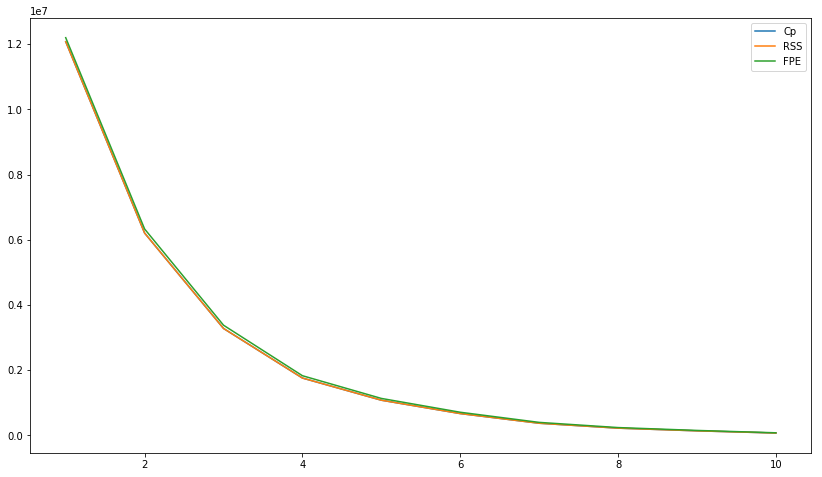

Optimal:
s* = 10
regressors = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
theta* = [ 0.          0.          0.          0.          0.          6.24188724
  6.42203793  8.4418811   8.82137153  9.8886097  11.77035191 11.64800501
 12.59822994 14.26311986 14.67341316]
results:

    s                            regressors  ...           RSS           FPE
0  10  [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]  ...  6.871098e+04  7.594371e+04
1   9     [7, 8, 9, 10, 11, 12, 13, 14, 15]  ...  1.358184e+05  1.486181e+05
2   8        [8, 9, 10, 11, 12, 13, 14, 15]  ...  2.182591e+05  2.364474e+05
3   7           [9, 10, 11, 12, 13, 14, 15]  ...  3.688321e+05  3.955868e+05
4   6              [10, 11, 12, 13, 14, 15]  ...  6.651979e+05  7.063442e+05
5   5                  [11, 12, 13, 14, 15]  ...  1.075598e+06  1.130757e+06
6   4                      [12, 13, 14, 15]  ...  1.755546e+06  1.827201e+06
7   3                          [13, 14, 15]  ...  3.277027e+06  3.376835e+06
8   2                              [1

In [ ]:
m = 15
n_list = [200]
theta = np.arange(15)
sigma_list = [0.3]
s = 10
for n in n_list: 
    for sigma in sigma_list:
        X = np.random.uniform(0, 10, size=(n, m))
        ksi = np.random.normal(0, sigma, size=n)
        y =X @ theta + ksi
        print('n = {}'.format(n))
        print('σ = {}'.format(sigma))
        print('X:{}'.format(X))
        print('y:{}'.format(y))
        #theta_pred, _, _, df = RMNK(X, y, s=s, printt=True, cr_df=True)
        p = np.flip(np.arange(m), axis=0)
        theta_pred, _, _, df = RMNK(X[:,p], y, s=s, printt=True, cr_df=True)
        df = df.drop(columns=['theta'])
        print('True values: θ= {}'.format(theta))
        print('Estimates: θ*= {}'.format(list(reversed(theta_pred[:,0]))))
        df = df.sort_values(by=['Cp','RSS', 'FPE'])
        #print('Estimates: θ*= {}'.format(theta_pred[:,0]))
        plt.plot(df['s'], df['Cp'], label='Cp')
        plt.plot(df['s'], df['RSS'], label='RSS')
        plt.plot(df['s'], df['FPE'], label='FPE')
        plt.legend()
        plt.show()
        print(df)
        print()
        A1(X,y,m,s,sequence='reverse',crs=['Cp','RSS', 'FPE'],plot=True)
        #A2(X,y,m,s,50, crs=['Cp','RSS', 'FPE'], min_crit ='Cp')
        #A3(X,y,m,s, crs=['Cp','RSS', 'FPE'], min_crit ='Cp')
